# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from art.utils import load_cifar10
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

/home/alper/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# Model

In [3]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    return model

In [4]:
model = create_model()

# Train

In [5]:
classifier = KerasClassifier(
    model=model,
    clip_values=(min_, max_),
    use_logits=False,
    preprocessing=(0.5, 1)
)

In [6]:
classifier.fit(x_train, y_train, nb_epochs=10, verbose=1)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 97us/sample - loss: 1.3474 - accuracy: 0.5162
Epoch 2/10
50000/50000 [==============================] - 3s 66us/sample - loss: 0.8930 - accuracy: 0.6866
Epoch 3/10
50000/50000 [==============================] - 3s 66us/sample - loss: 0.7001 - accuracy: 0.7559
Epoch 4/10
50000/50000 [==============================] - 3s 67us/sample - loss: 0.5576 - accuracy: 0.8063
Epoch 5/10
50000/50000 [==============================] - 3s 68us/sample - loss: 0.4153 - accuracy: 0.8563
Epoch 6/10
50000/50000 [==============================] - 6s 113us/sample - loss: 0.2873 - accuracy: 0.9012
Epoch 7/10
50000/50000 [==============================] - 3s 67us/sample - loss: 0.1718 - accuracy: 0.9412
Epoch 8/10
50000/50000 [==============================] - 3s 65us/sample - loss: 0.1096 - accuracy: 0.9616
Epoch 9/10
50000/50000 [==============================] - 3s 69us/sample - loss: 0.0763 - accuracy: 0.9739
Epoch 10/10
5

# Attack

In [7]:
art_model = KerasClassifier(
    model=model, 
    clip_values=(min_, max_),
    use_logits=False,
    preprocessing=(0.5, 1)
)

In [8]:
boundary_attack = BoundaryAttack(art_model, max_iter=100, targeted=False)

In [9]:
adv_test = boundary_attack.generate(x=x_test[:16])

Boundary attack:   0%|          | 0/16 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/100 [00:00<?, ?it/s]

# Results

In [10]:
safe_preds = np.argmax(art_model.predict(x_test[:16]), axis=1)

In [11]:
safe_preds

array([3, 8, 8, 0, 6, 5, 1, 6, 3, 1, 0, 9, 5, 7, 9, 6])

In [12]:
y_test = np.argmax(y_test[:16], axis=1)

In [13]:
safe_model_scores = {
    'ACC': accuracy_score(y_test, safe_preds),
    'PREC': precision_score(y_test, safe_preds, average='weighted'),
    'REC': recall_score(y_test, safe_preds, average='weighted'),
    'F1': f1_score(y_test, safe_preds, average='weighted')
}

In [14]:
safe_model_scores

{'ACC': 0.875, 'PREC': 0.90625, 'REC': 0.875, 'F1': 0.8791666666666667}

In [15]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [16]:
adv_model_scores = {
    'ACC': accuracy_score(y_test, adv_preds),
    'PREC': precision_score(y_test, adv_preds, average='weighted'),
    'REC': recall_score(y_test, adv_preds, average='weighted'),
    'F1': f1_score(y_test, adv_preds, average='weighted')
}

In [17]:
adv_model_scores

{'ACC': 0.0625, 'PREC': 0.0625, 'REC': 0.0625, 'F1': 0.0625}

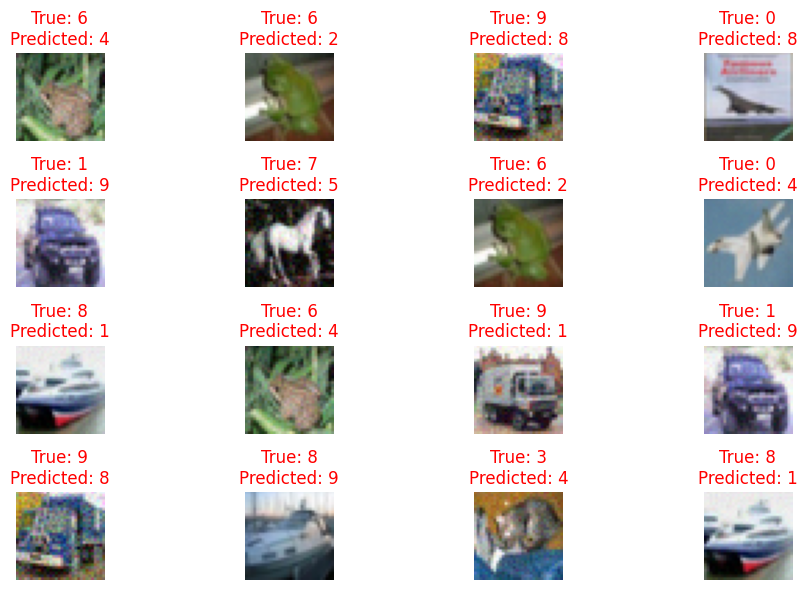

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]], cmap='gray')
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()